<a href="https://colab.research.google.com/github/maxrinal/nlp-disaster/blob/master/TP2_CODES/DiCaro_97582/MejorLGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning**

## Importo Librerías

In [ ]:
#! python -m textblob.download_corpora
#!pip install --user -U nltk
#nltk.download('punkt')
#!pip install kaggle
#!pip install catboost
!pip install bayesian-optimization

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from textblob import TextBlob
from wordcloud import WordCloud
import string,re
import urllib.parse
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk .tokenize.regexp import regexp_tokenize
import spacy
import keras
import html
import re
import urllib
import warnings
import time
import random

from google.colab import drive
#from google.colab import files
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')

from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import lightgbm as lgb

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.decomposition import PCA

In [ ]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

plt.style.use('default') #Haciendo los gráficos más bonitos en matplotlib

sns.set(style = 'whitegrid') #Seteando tipo de grid en sns

pd.options.display.float_format = '{:20,.2f}'.format #Suprimimos la notacion científica en los outputs

warnings.filterwarnings("ignore")

In [ ]:
print('re version', re.__version__)
print('nltk version', nltk.__version__)
print('spacy version', spacy.__version__)
print('keras version', keras.__version__)

re version 2.2.1
nltk version 3.2.5
spacy version 2.2.4
keras version 2.4.3


## Importo Datos

In [ ]:
train_original = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/train.csv', encoding = 'utf-8')
test_original = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/test.csv', encoding = 'utf-8')

In [ ]:
test_original.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train = pd.concat([train_original, test_original])[['id', 'keyword', 'location', 'text', 'target']]

# Limpieza

### Funciones

In [ ]:
caracteres_extraños = ['\u017E', '\u017D', '\u017C', '\u017B', '\u017A', '\u0179', '\u0178', '\u0177', '\u0176', '\u00FF', '\u00FD', '\u00DD', '\u0175',\
                         '\u0174', '\u0173', '\u0172', '\u0171', '\u0170', '\u016F', '\u016E', '\u016D', '\u016C', '\u016B', '\u016A', '\u0169', '\u0168',\
                         '\u00FC', '\u00FB', '\u00FA', '\u00F9', '\u00DC', '\u00DB', '\u00DA', '\u00D9', '\u0167', '\u0166', '\u0165', '\u0164', '\u0163',\
                         '\u0162', '\u017F', '\u0161', '\u0160', '\u015F', '\u015E', '\u015D', '\u015C', '\u015B', '\u015A', '\u0159', '\u0158', '\u0157',\
                         '\u0156', '\u0155', '\u0154', '\u0151', '\u0150', '\u014F', '\u014E', '\u014D', '\u014C', '\u00F8', '\u00F6', '\u00F5', '\u00F4',\
                         '\u00F3', '\u00F2', '\u00D8', '\u00D6', '\u00D5', '\u00D4', '\u00D3', '\u00D2', '\u014B', '\u014A', '\u0149', '\u0148', '\u0147',\
                         '\u0146', '\u0145', '\u0144', '\u0143', '\u00F1', '\u00D1', '\u0142', '\u0141', '\u0140', '\u013F', '\u013E', '\u013D', '\u013C',\
                         '\u013B', '\u013A', '\u0139', '\u0138', '\u0137', '\u0136', '\u0135', '\u0134', '\u0131', '\u0130', '\u012F', '\u012E', '\u012D',\
                         '\u012C', '\u012B', '\u012A', '\u0129', '\u0128', '\u00EF', '\u00EE', '\u00ED', '\u00EC', '\u00CF', '\u00CE', '\u00CD', '\u00CC',\
                         '\u0127', '\u0126', '\u0125', '\u0124', '\u0123', '\u0122', '\u0121', '\u0120', '\u011F', '\u011E', '\u011D', '\u011C', '\u011B',\
                         '\u011A', '\u0119', '\u0118', '\u0117', '\u0116', '\u0115', '\u0114', '\u0113', '\u0112', '\u00EB', '\u00EA', '\u00E9', '\u00E8',\
                         '\u00CB', '\u00CA', '\u00C9', '\u00C8', '\u0111', '\u0110', '\u010F', '\u010E', '\u00F0', '\u00D0', '\u010D', '\u010C', '\u010B',\
                         '\u010A', '\u0109', '\u0108', '\u0107', '\u0106', '\u00E7', '\u00C7', '\u0105', '\u0104', '\u0103', '\u0102', '\u0101', '\u0100',\
                         '\u00E5', '\u00E4', '\u00E3', '\u00E2', '\u00E1', '\u00E0', '\u00C5', '\u00C4', '\u00C3', '\u00C2', '\u00C0', '\u00C1']

monosilabos = ['£', '¤', '¨', '«', '¬', '´', '¡']

words_to_clean = stopwords.words('english')
words_to_clean.append('')

In [ ]:
def remuevo_caracteres_de_lista (texto, lista):
  for caracter in lista:
    texto = texto.replace(caracter, ' ')
  return texto

def clean_texto (texto, caracteres_extraños, monosilabos):
  texto = re.compile(r'https?://\S+|www\.\S+').sub(r'',texto) #Removing urls
  texto = html.unescape(texto)
  texto = urllib.parse.unquote(str(texto))
  texto = re.compile(r'<.*?>').sub(r'',texto) #Removing HTML tags
  texto = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE).sub(r'', texto)
  texto = texto.translate(str.maketrans('','',string.punctuation))
  texto = texto.lower()
  texto = texto.translate(str.maketrans('','','1234567890'))
  texto = texto.replace('\n', ' ').replace('å', ' ').replace('ê', ' ').replace('û', ' ').replace('[^\w\s]',' ').replace('÷', ' ').replace('ª', ' ')\
             .replace('ì', ' ').replace('¢', ' ').replace('\x89', ' ').replace('\x9d', ' ').replace('ã', ' ').replace('ï', ' ').replace('©', ' ')\
             .replace('ó', ' ').replace('ò', ' ').replace('â', ' ').replace('\x9b', ' ').replace('\x8a', ' ').replace('\x93', ' ').replace('\x8f', ' ')\
             .replace('\x8c', ' ').replace('¼', ' ').replace('¥', ' ').replace('\x92', ' ').replace('·', ' ').replace('\x82', ' ').replace('Û', ' ')\
             .replace('Ó', ' ').replace('Ê', ' ').replace('Ï', ' ')
  texto = remuevo_caracteres_de_lista(texto, caracteres_extraños)
  texto = remuevo_caracteres_de_lista(texto, monosilabos)
  return texto
                        
def custom_tokenize (notes, caracteres_extraños, monosilabos):
  notes = [clean_texto(texto, caracteres_extraños, monosilabos) for texto in notes]
  tokens = regexp_tokenize(' '.join(notes), pattern = '\s+', gaps = True)
  return tokens

def paso_diccionario_word_frecuencia (lista):
  dic = {}
  for word in lista:
    if word in dic.keys():
      dic[word] += 1
    else:
      dic[word] = 1
  return dic

def saco_palabras_cortas (lista_tokens_frecuencia):
  for i, word in enumerate(lista_tokens_frecuencia):
    if (len(word[0]) < 3):
      lista_tokens_frecuencia.pop(i)
  return lista_tokens_frecuencia

def sumo_listas (lista1, lista2):
  for elemento in lista1:
    if not elemento in lista2:
      lista2.append(elemento)
  return lista2

## Limpieza Location

In [ ]:
train['location'] = train.location.transform(lambda x: html.unescape(x))
train['location'] = train.location.transform(lambda x: urllib.parse.unquote(str(x)))
train['location'] = train.location.transform(lambda x: re.compile(r'<.*?>').sub(r'', x))
train['location'] = train.location.transform(lambda x: x.translate(str.maketrans('','',string.punctuation)))
train['location'] = train.location.transform(lambda x: x.lower())
train['location'] = train.location.transform(lambda x: x.translate(str.maketrans('','','1234567890')))
train['location'] = train.location.transform(lambda x: remuevo_caracteres_de_lista(x, caracteres_extraños))
train['location'] = train.location.transform(lambda x: remuevo_caracteres_de_lista(x, monosilabos))

In [ ]:
labelbinarizer = LabelBinarizer()
X_location = labelbinarizer.fit_transform(train.location)

In [ ]:
np.shape(X_location)

(10876, 4134)

## Limpieza Keyword

In [ ]:
train['keyword'] = train.keyword.transform(lambda x: urllib.parse.unquote(str(x)))
#mlb = MultiLabelBinarizer()
#labelencoder = LabelEncoder()
labelbinarizer = LabelBinarizer()
X_keyword = labelbinarizer.fit_transform(train.keyword)

In [ ]:
np.shape(X_keyword)

(10876, 222)

## Limpieza Texto

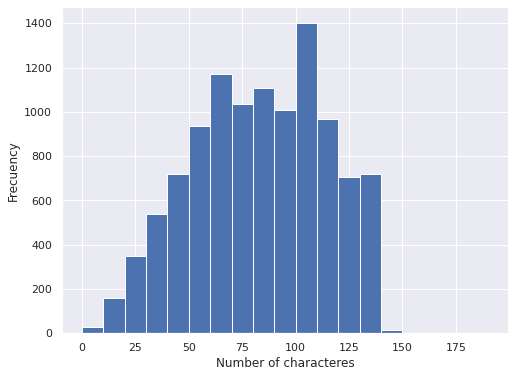

In [ ]:
train['text_len'] = train.text.transform(lambda x: len(clean_texto(x, caracteres_extraños, monosilabos)))

sns.set(font_scale = 1)
plt.figure(figsize = (8, 6))

plt.hist(train.text_len.values, bins = range(0, 200, 10))
plt.xlabel('Number of characteres')
plt.ylabel('Frecuency')
plt.show()

In [ ]:
notes = list(train.text.values)
#random.seed(42)
#random.shuffle(notes)
tokens = custom_tokenize(notes, caracteres_extraños, monosilabos)
palabras_para_sacar = [word for word in tokens if len(word) < 3]
words_to_clean = sumo_listas(palabras_para_sacar, words_to_clean)
#tokens = sorted(tokens)
#dic_tokens = paso_diccionario_word_frecuencia(tokens)
#lista_tokens_frecuencia = list(dic_tokens.items())
#lista_tokens_frecuencia_limpia = saco_palabras_cortas(lista_tokens_frecuencia)
#lista_tokens_frecuencia_limpia = saco_palabras_cortas(lista_tokens_frecuencia_limpia)

In [ ]:
corpus = [clean_texto(texto, caracteres_extraños, monosilabos) for texto in notes]

In [ ]:
vectorizer = CountVectorizer(analyzer = 'word', stop_words = words_to_clean, lowercase = True, strip_accents = 'ascii', ngram_range = (1, 1)) #(2, 2) bigrams
X_texto_vectorizer = vectorizer.fit_transform(corpus)
X_texto = X_texto_vectorizer.toarray()
np.shape(X_texto)

(10876, 20645)

# Modelo

In [ ]:
X_text_len = labelbinarizer.fit_transform(train.text_len)
np.shape(X_text_len)

(10876, 141)

### **PCA**

In [ ]:
#del X_texto_vectorizer
#X_texto_norm = StandardScaler().fit_transform(X_texto) #Estandarizo la matriz para PCA. No influye en en un arbol
#pca = PCA(n_components = 8000)
#X_texto_red = pca.fit_transform(X_texto_norm)

In [ ]:
#pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(X_texto_norm)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['c1', 'c2'])
#principalDf_train = principalDf.loc[0:7612, :]
#finalDf_train = pd.concat([principalDf_train, train_original.target], axis = 1)

In [ ]:
#finalDf.head(1)

In [ ]:
#f, ax = plt.subplots(figsize = (25, 50))
#sns.scatterplot(finalDf_train.c1, finalDf_train.c2, hue =  finalDf_train.target)

In [ ]:
#principalDf_test = principalDf.loc[7613:, :]
#f, ax = plt.subplots(figsize = (25, 50))
#sns.scatterplot(finalDf_train.c1, finalDf_train.c2, hue =  finalDf_train.target)

### **Split**

In [ ]:
y = train_original.target.values
#X = X_texto_red
X = X_texto
X = np.hstack((X, X_keyword))
#X = np.hstack((X, X_text_len))
X = np.hstack((X, X_location))
#X = np.delete(X, 23235, axis = 1) #Le saco el location pionner....

In [ ]:
#del X_texto_red

In [ ]:
np.shape(y)

(7613,)

In [ ]:
np.shape(X)

(10876, 25001)

In [ ]:
X_fit = X[0:7613]
X_submit = X[7613:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fit, y, test_size = 0.05, random_state = 123)

In [ ]:
#del X_fit

# Optimización Bayesiana

In [ ]:
def bayes_parameter_opt_lgb(X_train, y_train, init_round = 15, opt_round = 25, n_folds = 1, random_seed = 0, n_estimators = 7155, output_process=False):
    # prepare data
    lgb_train = lgb.Dataset(X_train, y_train)
    # parameters

    def lgb_eval(learning_rate, num_leaves, min_split_gain, min_data_in_leaf, min_child_weight, max_depth, feature_fraction):
      
        params = {"objective" : "regression", "metric" : 'rmse'}
        params['learning_rate'] = learning_rate
        params['num_leaves'] = int(round(num_leaves))
        params['min_split_gain'] = min_split_gain
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_child_weight'] = min_child_weight
        params['max_depth'] = int(round(max_depth))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
         


        cv_result = lgb.cv(params, lgb_train, nfold=n_folds, seed = random_seed, stratified=False)
        return (-1.0 * np.array(cv_result['rmse-mean'])).max()
    
        # range 
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate' : (0.1, 0.15),
                                            'num_leaves' : (100, 200),
                                            'min_split_gain' : (0.001, 0.1),
                                            'min_data_in_leaf' : (10, 30),
                                            'min_child_weight' : (5, 50),
                                            'max_depth' : (5, 9),
                                            'feature_fraction': (0.1, 0.9)}, random_state=0)

        # optimize
    lgbBO.maximize(init_points = init_round, n_iter = opt_round, acq = 'ei')

        # output optimization process
    if output_process == True: 
      lgbBO.points_to_csv("bayes_opt_result.csv")
      files.download('bayes_opt_result.csv')


        # return best parameters
    return lgbBO.res #['max']['max_params']

opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round = 10, opt_round = 10, n_folds = 7, n_estimators = 7155)

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | min_da... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.4566   |  0.5391   |  0.1358   |  7.411    |  29.52    |  18.47    |  0.06494  |  143.8    |
|  2        | -0.4778   |  0.8134   |  0.1482   |  6.534    |  40.63    |  20.58    |  0.05724  |  192.6    |
|  3        | -0.4789   |  0.1568   |  0.1044   |  5.081    |  42.47    |  25.56    |  0.08713  |  197.9    |
|  4        | -0.4435   |  0.7393   |  0.1231   |  8.122    |  10.32    |  22.8     |  0.01519  |  194.5    |
|  5        | -0.4773   |  0.5175   |  0.1207   |  6.058    |  39.84    |  19.12    |  0.05727  |  101.9    |
|  6        | -0.4799   |  0.5941   |  0.1306   |  7.468    |  47.47    |  23.64    |  0.03659  |  143.7    |
|  7        | -0.4754   |  0.6581   |  0.103    |  7.667    |  35.18    |  14.21    |  0.01376  |  131.5    |
|  8      

In [ ]:
i = 18
params = opt_params[i]['params']
params['max_depth'] = int(round(opt_params[i]['params']['max_depth'], 0))
params['num_leaves'] = int(round(opt_params[i]['params']['num_leaves'], 0))
params['min_data_in_leaf'] = int(round(opt_params[i]['params']['min_data_in_leaf'], 0))
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['n_estimators'] = 7155
params['feature_fraction'] = 1
#params['bagging_freq'] = 5
#params['max_bin'] = 409
#params['min_child_samples'] = 10
#params['num_iteraciones'] = 100
params

{'feature_fraction': 1,
 'learning_rate': 0.1312663264284989,
 'max_depth': 9,
 'metric': 'rmse',
 'min_child_weight': 7.044261617315253,
 'min_data_in_leaf': 23,
 'min_split_gain': 0.0789353879168263,
 'n_estimators': 7155,
 'num_leaves': 200,
 'objective': 'regression'}

# LGBM

In [ ]:
lgb_train = lgb.Dataset(X_fit, y)
lgb_eval = lgb.Dataset(X_test, y_test, reference = lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 120,
                valid_sets = lgb_eval,
                early_stopping_rounds = 1000)

preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.490797
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's rmse: 0.487521
[3]	valid_0's rmse: 0.483801
[4]	valid_0's rmse: 0.479978
[5]	valid_0's rmse: 0.477402
[6]	valid_0's rmse: 0.474779
[7]	valid_0's rmse: 0.471065
[8]	valid_0's rmse: 0.467601
[9]	valid_0's rmse: 0.465453
[10]	valid_0's rmse: 0.462775
[11]	valid_0's rmse: 0.46222
[12]	valid_0's rmse: 0.459544
[13]	valid_0's rmse: 0.458048
[14]	valid_0's rmse: 0.454944
[15]	valid_0's rmse: 0.454004
[16]	valid_0's rmse: 0.452626
[17]	valid_0's rmse: 0.451089
[18]	valid_0's rmse: 0.450082
[19]	valid_0's rmse: 0.448565
[20]	valid_0's rmse: 0.446774
[21]	valid_0's rmse: 0.445498
[22]	valid_0's rmse: 0.44426
[23]	valid_0's rmse: 0.444064
[24]	valid_0's rmse: 0.442118
[25]	valid_0's rmse: 0.441564
[26]	valid_0's rmse: 0.440139
[27]	valid_0's rmse: 0.439043
[28]	valid_0's rmse: 0.437992
[29]	valid_0's rmse: 0.43799
[30]	valid_0's rmse: 0.437325
[31]	valid_0's rmse: 0.436383
[32]	valid_0's rms

<Figure size 1800x2160 with 0 Axes>

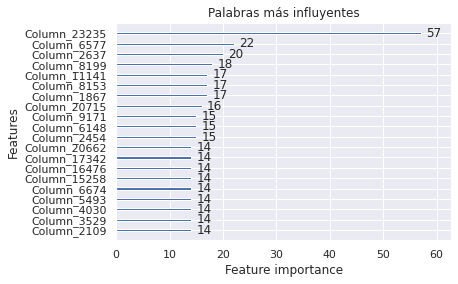

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize = (25, 30))
lgb.plot_importance(gbm,  max_num_features = 20, title = "Palabras más influyentes")

In [ ]:
print(vectorizer.get_feature_names()[2454])
print(vectorizer.get_feature_names()[6577])
print(vectorizer.get_feature_names()[6679])
print(vectorizer.get_feature_names()[9842])
print(vectorizer.get_feature_names()[9976])
print(vectorizer.get_feature_names()[2776])
print(vectorizer.get_feature_names()[19842])
print(vectorizer.get_feature_names()[9])
print(vectorizer.get_feature_names()[4])
print(vectorizer.get_feature_names()[2676])
print(vectorizer.get_feature_names()[16698])
print(vectorizer.get_feature_names()[4030])

In [ ]:
features = np.hstack((vectorizer.get_feature_names(), train.keyword.unique()))
#features = np.hstack((features, train.columns[5]))
features = np.hstack((features, train.location.unique()))

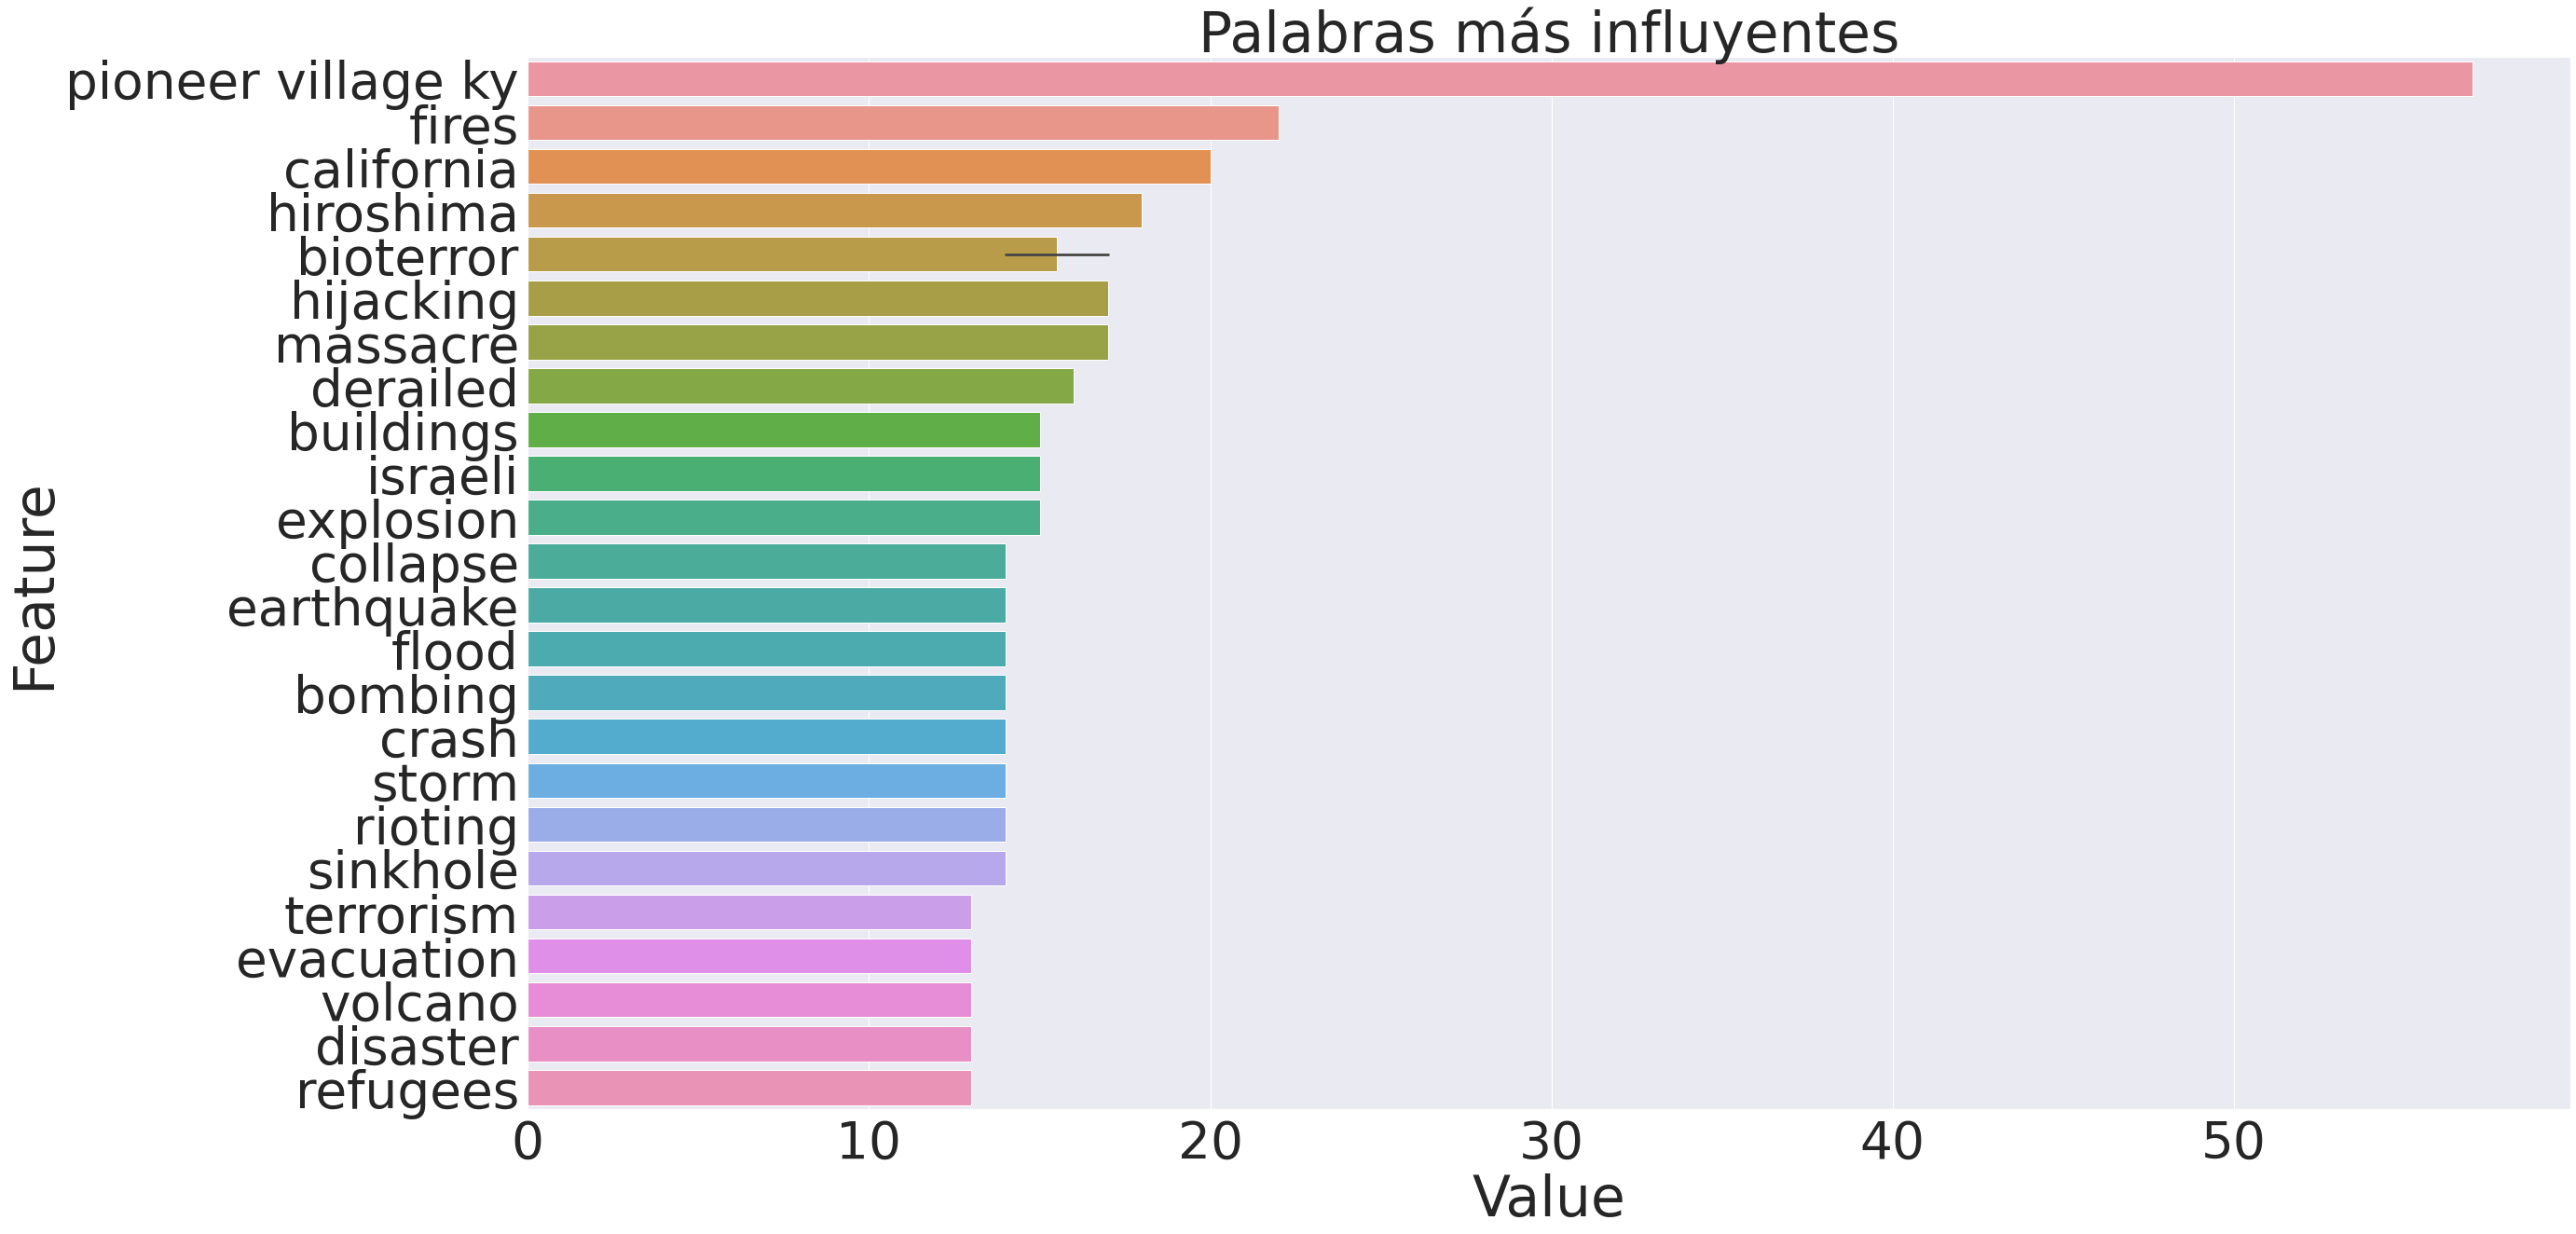

In [ ]:
feature_imp = pd.DataFrame({'Value':gbm.feature_importance(), 'Feature': features})
plt.figure(figsize = (40, 20))
sns.set(font_scale = 5)
sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", ascending = False)[0:25])
plt.title('Palabras más influyentes')
plt.tight_layout()
#plt.savefig('lgbm_importances-01.png')
plt.show()

In [ ]:
preds_submit = gbm.predict(X_submit, num_iteration=gbm.best_iteration)

In [ ]:
resultados = pd.DataFrame(data = preds_submit, columns = ['target'])
resultados.insert(0, 'id', test_original.id)
resultados['target'] = resultados.target.transform(lambda x: 1 if x > 0.5 else 0)

In [ ]:
resultados.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [ ]:
resultados.to_csv('submission_8_LGBM.csv', header = True, index = False) 
files.download('submission_8_LGBM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>